In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pickle

from metrics import confusion_matrix_plot, calculate_recall, calculate_roc_auc, calculate_precision
from preprocessing import process_data

In [3]:
data = pd.read_csv('data/testset_C.csv', sep=';')
data = process_data(data)

train_data, test_data = train_test_split(data, stratify=data['productgroup'], test_size=0.2, random_state=1)

In [4]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
tfidf.fit(train_data['concat_text'])

train_features = tfidf.transform(train_data['concat_text'])
test_features = tfidf.transform(test_data['concat_text'])

In [5]:
enc = OneHotEncoder(sparse=False)
train_y = enc.fit_transform(train_data[['productgroup']])
test_y = enc.transform(test_data[['productgroup']])

In [6]:
train_pool = Pool(train_features, label=train_y)
test_pool = Pool(test_features, label=test_y)

In [7]:
clf = CatBoostClassifier(
    loss_function='MultiCrossEntropy',
    eval_metric='Accuracy',
    iterations=200,
    class_names=enc.categories_[0],
    learning_rate=0.21
)
clf.fit(train_pool, eval_set=test_pool, metric_period=1, plot=False, verbose=50, early_stopping_rounds=10)

0:	learn: 0.7818750	test: 0.7925000	best: 0.7925000 (0)	total: 1.03s	remaining: 3m 24s
50:	learn: 0.9857813	test: 0.9843750	best: 0.9843750 (48)	total: 44s	remaining: 2m 8s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.989375
bestIteration = 76

Shrink model to first 77 iterations.


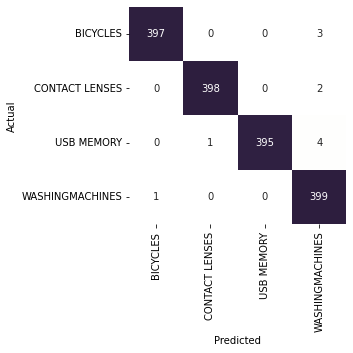

In [11]:
preds_bool = clf.predict(test_pool)
preds = clf.predict_proba(test_pool)

confusion_matrix_plot(test_y, preds, enc.categories_[0])

In [13]:
calculate_recall(test_y, preds_bool)
calculate_precision(test_y, preds_bool)
calculate_roc_auc(test_y, preds)


    recall: 0.9894
    

    precision: 0.9994
    

    roc auc macro: 0.9999,
    roc auc micro: 0.9999
    


In [14]:
predicted_cat = np.argmax(preds, axis=1)
true_cat = np.argmax(test_y, axis=1)

wrong_indexes = np.where(predicted_cat != true_cat)[0]
ind_to_category = {ind: cat for ind, cat in enumerate(enc.categories_[0])}

for i in wrong_indexes:
    print(test_data['concat_text'].iloc[i])
    print(f'true_cat: {ind_to_category[true_cat[i]]}', f'predicted: {ind_to_category[predicted_cat[i]]}')
    print()

fashion ean eyelike monatslinse 1 25 1st 73
true_cat: CONTACT LENSES predicted: WASHINGMACHINES

verbatim store n go swivel usbdrive 16gbred gr h100 general hardware
true_cat: USB MEMORY predicted: WASHINGMACHINES

polar polar pulsuhr v800 hr  black  90060770 sports 29000multisports 29170heartratewatches sportscomputers gpsde
true_cat: WASHINGMACHINES predicted: BICYCLES

None sandisk cruzer ultra flair 128gb 3 0 1
true_cat: USB MEMORY predicted: WASHINGMACHINES

None 85880 4gb minimo  4gb minimo 4005930
true_cat: USB MEMORY predicted: CONTACT LENSES

bergamont bergamont kiez flow petrol l 1 1 4
true_cat: BICYCLES predicted: WASHINGMACHINES

sandisk sandisk connect200gb video dvd tv   mediaplayer   stream client   streaming clients
true_cat: USB MEMORY predicted: WASHINGMACHINES

None acuvue oasys 14 tageslinsen
true_cat: CONTACT LENSES predicted: WASHINGMACHINES

None proph md wave aktion 0 63
true_cat: BICYCLES predicted: WASHINGMACHINES

None kingston data traveler se9 mit 109
true_

In [17]:
with open('models/tf_idf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
    
with open('models/clf.pkl', 'wb') as f:
    pickle.dump(clf, f)
    
with open('models/ind_to_category.pkl', 'wb') as f:
    pickle.dump(ind_to_category, f)